In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math
from tqdm import tqdm
from jpype import *

In [2]:
def pbc_distance(x1, x2, L):
    dx = abs(x1[0] - x2[0])
    dx = min(dx, L - dx)
    
    dy = abs(x1[1] - x2[1])
    dy = min(dy, L - dy)
    return np.sqrt(dx**2 + dy**2)

In [3]:
class XYModel2D:
    def __init__(self, L, T, J=1):
        self.L = L
        self.T = T
        self.J = J
        self.t_interval = L * L
        self.theta = np.random.uniform(0, 2 * np.pi, (L, L))

    def __delta_energy(self, x, y, new_angle):
        L = self.L
        theta = self.theta
        
        dE = 0.0
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            xn, yn = (x + dx) % L, (y + dy) % L
            dE += -self.J * (np.cos(theta[xn, yn] - new_angle) -
                             np.cos(theta[xn, yn] - theta[x, y]))
        return dE

    def monte_carlo_step(self):
        x, y = np.random.randint(0, self.L), np.random.randint(0, self.L)
        new_angle = np.random.uniform(0, 2*np.pi)
        dE = self.__delta_energy(x, y, new_angle)
        
        if dE < 0 or np.random.rand() < np.exp(-dE / self.T):
            self.theta[x, y] = new_angle

    def SimulationFor1Time(self):
        for _ in range(self.t_interval):
            self.monte_carlo_step()
    
    def equilibrate(self, max_steps=10_000):
        energy_temp = 0
        for k in range(max_steps):
            self.SimulationFor1Time()
            energy = self.total_energy()
            if ((abs(energy-energy_temp)/abs(energy)<1e-5) & (k>500)) or k == max_steps-1:
                print('\nequilibrium state is reached at T=%.1f'%self.T)
                print('#sweep=%i'%k)
                break
            energy_temp = energy

    def compute_vorticity(self):
        L = self.L
        vort = []
        for i in range(L):
            for j in range(L):
                angles = [
                    self.theta[i, j],
                    self.theta[i, (j+1)%L],
                    self.theta[(i+1)%L, (j+1)%L],
                    self.theta[(i+1)%L, j]
                ]
                delta = []
                for k in range(4):
                    d = angles[(k+1)%4] - angles[k]
                    d = (d + np.pi) % (2 * np.pi) - np.pi
                    delta.append(d)
                winding = sum(delta)
                n = int(np.round(winding / (2 * np.pi)))
                if n != 0:
                    vort.append([i,j,n])
        return vort
    
    def vortex_vortex_interaction(self, a=1):
        vort = self.compute_vorticity()
        if len(vort) < 2:
            return 0
        V = 0
        for v_pair in combinations(vort, 2):
            V += v_pair[0][-1]* v_pair[1][-1]*np.log(pbc_distance(v_pair[0][:2], v_pair[1][:2], self.L)/a)
        return -np.pi * self.J * V

    def plot_spin_with_vortices(self):
        L = self.L
        U = np.cos(self.theta)
        V = np.sin(self.theta)
        vort = self.compute_vorticity()
    
        fig, ax = plt.subplots(figsize=(6, 6))
        X, Y = np.meshgrid(np.arange(L), np.arange(L))
    
        # Plot spin field
        ax.quiver(X, Y, U, V, pivot='mid', scale=50)
    
        ax.set_xticks([]); ax.set_yticks([])
    
        # Overlay vortex markers at plaquette centers
        for v in vort:
            if v[-1] == 1:
                ax.plot(v[1]+0.5, v[0]+0.5, 'ro', markersize=6)
                
            elif v[-1] == -1:
                ax.plot(v[1]+0.5, v[0]+0.5, 'bo', markersize=6)
        
        plt.show()

    def sample(self, n_samples):
        V_t = []
        X_t = []
        for i in tqdm(range(n_samples)):
            self.SimulationFor1Time()
            #self.plot_spin_with_vortices()
            V_t.append(self.vortex_vortex_interaction())
            X_t.append(self.theta.flatten())
        return V_t, X_t

    
    def magnetization(self):
        mx = np.cos(self.theta).sum()
        my = np.sin(self.theta).sum()
        m = np.sqrt(mx ** 2 + my ** 2) / (self.L ** 2)
        return m

    def total_energy(self):
        E = 0.0
        for i in range(self.L):
            for j in range(self.L):
                theta = self.theta[i, j]
                neighbors = [
                    ((i + 1) % self.L, j),
                    (i, (j + 1) % self.L)
                ]
                for ni, nj in neighbors:
                    E -= self.J * np.cos(theta - self.theta[ni, nj])
        return E
    
    def run(self, steps):
        energies = []
        energies_squared = []
        magnetizations = []
    
        self.equilibrate()
        for step in range(steps):
            self.SimulationFor1Time()
            E = self.total_energy()
            M = self.magnetization()
            energies.append(E)
            energies_squared.append(E ** 2)
            magnetizations.append(M)

        return energies, energies_squared, magnetizations


In [525]:
temperatures = np.linspace(0.1, 2.5, 10)
heat_capacities = []
M = []
Ev = []
E2v = []

L = 32
N = L * L

for T in temperatures:
    model = XYModel2D(L=L, T=T)
    energies, energies_squared, magnetizations = model.run(steps=1000)

    M.append(np.mean(magnetizations))
    E_avg = np.mean(energies)
    E2_avg = np.mean(energies_squared)
    Ev.append(E_avg)
    E2v.append(E2_avg)

    Cv = (E2_avg - E_avg ** 2) / (N * T ** 2 )
    heat_capacities.append(Cv)


equilibrium state is reached at T=0.1
#sweep=572

equilibrium state is reached at T=0.4
#sweep=1254

equilibrium state is reached at T=0.6
#sweep=1101

equilibrium state is reached at T=0.9
#sweep=1030

equilibrium state is reached at T=1.2
#sweep=1279

equilibrium state is reached at T=1.4
#sweep=6529

equilibrium state is reached at T=1.7
#sweep=2169

equilibrium state is reached at T=2.0
#sweep=645

equilibrium state is reached at T=2.2
#sweep=1088

equilibrium state is reached at T=2.5
#sweep=9999


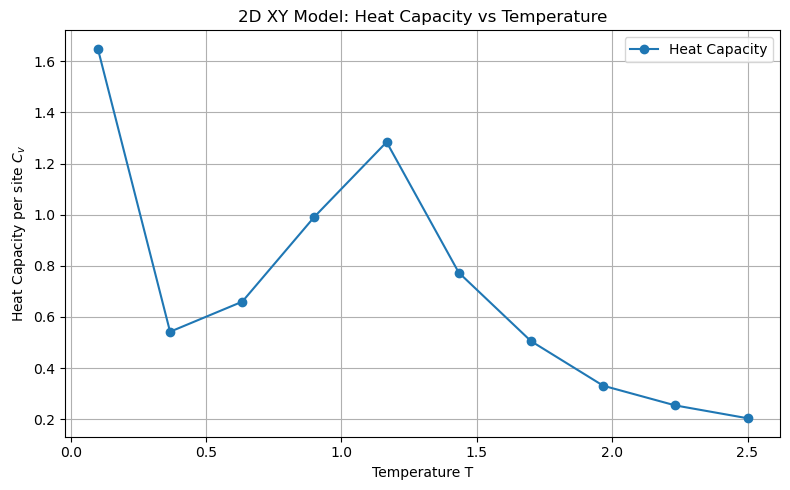

In [526]:
plt.figure(figsize=(8, 5))
plt.plot(temperatures, heat_capacities, 'o-', label='Heat Capacity')
plt.xlabel('Temperature T')
plt.ylabel('Heat Capacity per site $C_v$')
plt.title('2D XY Model: Heat Capacity vs Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

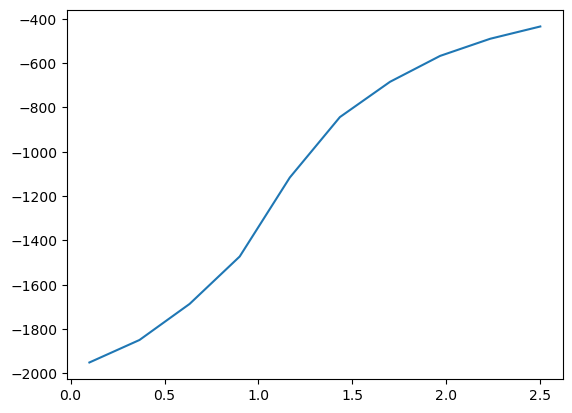

In [533]:
plt.plot(temperatures, Ev)

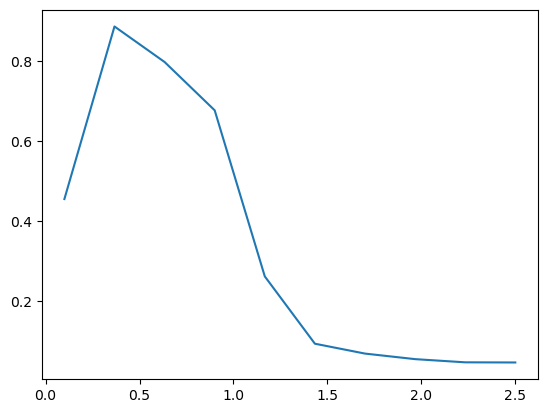

In [527]:
plt.plot(temperatures, M)


equilibrium state is reached at T=0.7
#sweep=504


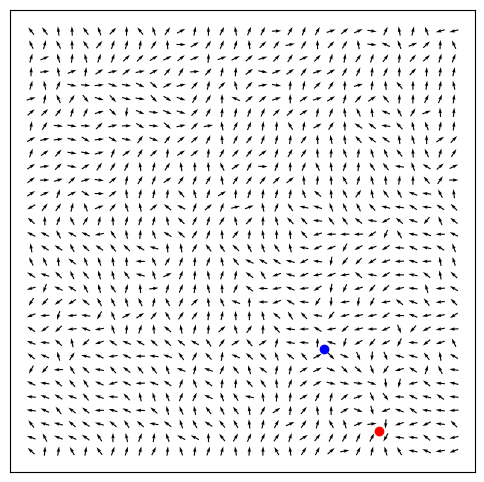

In [17]:
L = 32
T = 0.7
MyModel = XYModel2D(L, T)
MyModel.equilibrate()
#for _ in range(100):
#    MyModel.SimulationFor1Time()
MyModel.plot_spin_with_vortices()

In [19]:
V_t, X_t = MyModel.sample(5000)

100%|██████████| 5000/5000 [02:46<00:00, 29.99it/s]


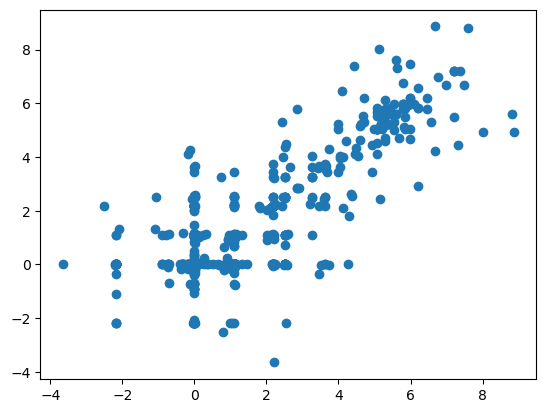

In [21]:
plt.scatter(V_t[:-1], V_t[1:])

In [7]:
if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "X:\\infodynamics-dist-1.6.1\\infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

def calc_mi_kraskov(a,b):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
    calc = calcClass()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(a, b)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

In [23]:
source1 = JArray(JDouble, 1)(V_t[:-1])
destination = JArray(JDouble, 1)(V_t[1:])

In [29]:
calc_mi_kraskov(source1, destination)

0.20772820830678285

In [33]:
def micro_mi(X_t, destination, return_list=False):
    if return_list:
        MI = []
    MI_SUM = 0
    for X in tqdm(np.array(X_t[:-1]).T):
        source2 = JArray(JDouble, 1)(X.tolist())
        micro = calc_mi_kraskov(source2, destination)
        
       # if mi<0:
       #     mi=0
        if return_list:
            MI.append(micro)
        MI_SUM += micro
    if return_list:
        return MI_SUM, MI
    return MI_SUM

In [37]:
MI_SUM, MI = micro_mi(X_t, destination, return_list=True)

100%|██████████| 1024/1024 [00:56<00:00, 18.26it/s]


In [45]:
MI_SUM, min(MI), max(MI)

(86.36169736205883, 0.05111514701087572, 0.13914655345985416)

In [39]:
MI_SUM-(L**2-1)*min(MI)

34.070901969932976

In [223]:
def calc_jmi_kraskov(a,b):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
    calc = calcClass()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    calc.initialise(np.shape(a)[1], 1)
    # 4. Supply the sample data:
    calc.setObservations(a, b)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

In [225]:
calc_jmi_kraskov(JArray(JDouble, 2)(np.array(X_t[:-1]).tolist()), destination)

0.0042705249693728575

In [261]:
jmi = 0
for _ in range(50):
    jmi += calc_jmi_kraskov(JArray(JDouble, 2)(np.array(X_t[:-1])[:,:2].tolist()), destination)
jmi/50

0.0072535179334517605

In [47]:
Ts = np.linspace(0.2, 2.0, 10)
L = 32

Vmi = []
Xmi = []

for t in Ts:
    model = XYModel2D(L=L, T=t)
    model.equilibrate()
    V_t, X_t = model.sample(5000)
    source1 = JArray(JDouble, 1)(V_t[:-1])
    destination = JArray(JDouble, 1)(V_t[1:])
    
    Vmi.append(calc_mi_kraskov(source1, destination))
    Xmi.append(micro_mi(X_t, destination))


equilibrium state is reached at T=0.2
#sweep=633


100%|██████████| 1024/1024 [01:15<00:00, 13.61it/s]



equilibrium state is reached at T=0.4
#sweep=706


100%|██████████| 1024/1024 [01:15<00:00, 13.49it/s]



equilibrium state is reached at T=0.6
#sweep=645


100%|██████████| 1024/1024 [01:26<00:00, 11.86it/s]



equilibrium state is reached at T=0.8
#sweep=2854


100%|██████████| 1024/1024 [01:03<00:00, 16.02it/s]



equilibrium state is reached at T=1.0
#sweep=1485


100%|██████████| 1024/1024 [01:01<00:00, 16.63it/s]



equilibrium state is reached at T=1.2
#sweep=1140


100%|██████████| 1024/1024 [00:56<00:00, 18.11it/s]



equilibrium state is reached at T=1.4
#sweep=770


100%|██████████| 1024/1024 [00:54<00:00, 18.64it/s]



equilibrium state is reached at T=1.6
#sweep=9999


100%|██████████| 1024/1024 [00:50<00:00, 20.19it/s]



equilibrium state is reached at T=1.8
#sweep=9999


100%|██████████| 1024/1024 [00:49<00:00, 20.57it/s]



equilibrium state is reached at T=2.0
#sweep=9999


100%|██████████| 1024/1024 [00:50<00:00, 20.35it/s]


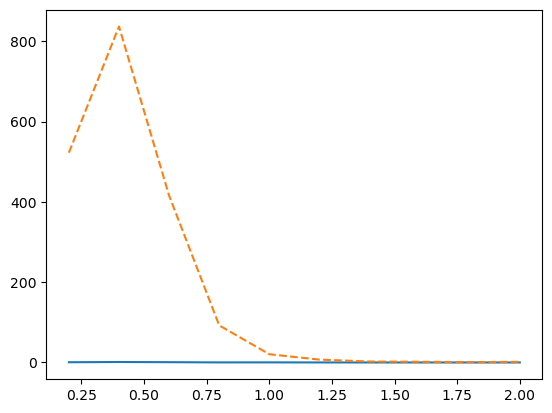

In [53]:
plt.plot(Ts, Vmi)
plt.plot(Ts, Xmi, '--')

In [65]:
Vmi[-1], Xmi[-1]

(0.0016002191719959313, 1.635686628592934)

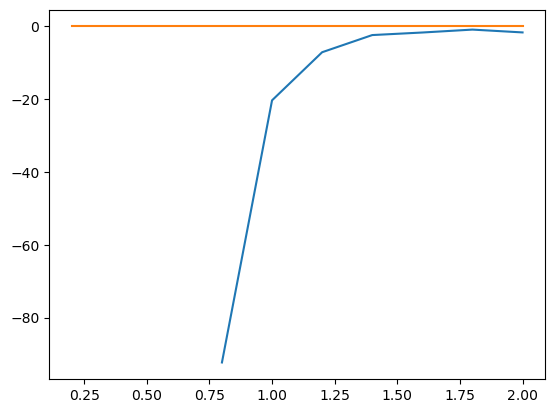

In [89]:
plt.plot(Ts[3:], np.array(Vmi)[3:]-np.array(Xmi)[3:])
plt.plot(Ts, np.zeros(10))